In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [3]:
# Define the exact solution
def exact_solution(x, t):
    return -torch.sin(pi*x)*torch.exp(-pi**2 * t)

def initial_condition(x):
    return -torch.sin(pi*x)

In [4]:
# assigning number of points
initial_pts = 200 
left_boundary_pts = 200 
right_boundary_pts = 200
residual_pts = 1000

In [5]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "ADAM"

x_init = 2*torch.rand((initial_pts,1))-1 # initial pts
t_init =  0*x_init
init =  torch.cat([x_init, t_init],1)
u_init = initial_condition(init[:,0]).reshape(-1, 1)
print(u_init.shape)


xb_left = -torch.ones((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, tb_left ],1)
u_b_l = 0*xb_left



xb_right = torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1)
u_b_r = 0*xb_right


x_interior = 2*torch.rand((residual_pts, 1))-1
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, u_init, b_left,  b_right), batch_size=200, shuffle=False)

torch.Size([200, 1])


In [6]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [7]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = u_init.shape[1], n_hidden_layers=4, neurons=20)


In [8]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)


In [9]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [9]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, u_initial, bd_left,  bd_right) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                u_initial_pred_ = model(initial)
                # for left boundary
                u_bd_left_pred_ = model(bd_left)
                # for right boundary
                u_bd_right_pred_ = model(bd_right)
                
                # residual calculation
                interior.requires_grad = True
                u_hat = model(interior)
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                grad_u_hat = torch.autograd.grad(u_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_x = grad_u_hat[:, 0]
                
                grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                u_xx = grad_grad_u_x[:, 0]
                u_t =  grad_u_hat[:, 1]
                
                
                # Item 1. below
                #loss = torch.mean((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, ))**p) + torch.mean((u_t.reshape(-1, ) - u_xx.reshape(-1, ))**p)+torch.mean((u_bd_left_pred_.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,))**p)
                loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))
 
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [10]:
n_epochs = 10000
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  62.431663513183594
################################  1  ################################
Loss:  51.80445861816406
################################  2  ################################
Loss:  42.20371627807617
################################  3  ################################
Loss:  37.07029724121094
################################  4  ################################
Loss:  32.626434326171875
################################  5  ################################
Loss:  28.381879806518555
################################  6  ################################
Loss:  24.615196228027344
################################  7  ################################
Loss:  21.29960823059082
################################  8  ################################
Loss:  18.367584228515625
################################  9  ################################
Loss:  15.713550567626953
################################  10  ######

/home/users/etudiant/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:202: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return Variable._execution_engine.run_backward(


Loss:  13.073493957519531
################################  16  ################################
Loss:  11.621142387390137
################################  17  ################################
Loss:  10.234692573547363
################################  18  ################################
Loss:  9.632940292358398
################################  19  ################################
Loss:  8.96223258972168
################################  20  ################################
Loss:  8.384251594543457
################################  21  ################################
Loss:  8.001083374023438
################################  22  ################################
Loss:  7.777948379516602
################################  23  ################################
Loss:  7.510253429412842
################################  24  ################################
Loss:  7.201189994812012
################################  25  ################################
Loss:  6.999340057373047
#############

Loss:  1.671762466430664
################################  112  ################################
Loss:  1.5967551469802856
################################  113  ################################
Loss:  1.6551611423492432
################################  114  ################################
Loss:  1.6572930812835693
################################  115  ################################
Loss:  1.626162052154541
################################  116  ################################
Loss:  1.572167992591858
################################  117  ################################
Loss:  1.5619601011276245
################################  118  ################################
Loss:  1.620839238166809
################################  119  ################################
Loss:  1.6533055305480957
################################  120  ################################
Loss:  1.656033992767334
################################  121  ################################
Loss:  1.6370218992233276

Loss:  1.7741786241531372
################################  196  ################################
Loss:  1.6734206676483154
################################  197  ################################
Loss:  1.5881708860397339
################################  198  ################################
Loss:  1.4735281467437744
################################  199  ################################
Loss:  1.8745149374008179
################################  200  ################################
Loss:  1.7958154678344727
################################  201  ################################
Loss:  1.4885399341583252
################################  202  ################################
Loss:  1.4875630140304565
################################  203  ################################
Loss:  1.613574504852295
################################  204  ################################
Loss:  1.5731853246688843
################################  205  ################################
Loss:  1.373454809188

Loss:  1.4377480745315552
################################  285  ################################
Loss:  1.3468726873397827
################################  286  ################################
Loss:  1.3269447088241577
################################  287  ################################
Loss:  1.4530041217803955
################################  288  ################################
Loss:  1.35393226146698
################################  289  ################################
Loss:  1.3564037084579468
################################  290  ################################
Loss:  1.3859567642211914
################################  291  ################################
Loss:  1.3004435300827026
################################  292  ################################
Loss:  1.2867571115493774
################################  293  ################################
Loss:  1.2592865228652954
################################  294  ################################
Loss:  1.2660467624664

Loss:  1.3723087310791016
################################  375  ################################
Loss:  1.2305846214294434
################################  376  ################################
Loss:  1.288161277770996
################################  377  ################################
Loss:  1.2939550876617432
################################  378  ################################
Loss:  1.1965843439102173
################################  379  ################################
Loss:  1.2559953927993774
################################  380  ################################
Loss:  1.4536724090576172
################################  381  ################################
Loss:  1.4271291494369507
################################  382  ################################
Loss:  1.3615256547927856
################################  383  ################################
Loss:  1.3770743608474731
################################  384  ################################
Loss:  1.261408805847

Loss:  1.3138848543167114
################################  465  ################################
Loss:  1.234607219696045
################################  466  ################################
Loss:  1.1974034309387207
################################  467  ################################
Loss:  1.2906620502471924
################################  468  ################################
Loss:  1.3103582859039307
################################  469  ################################
Loss:  1.2731343507766724
################################  470  ################################
Loss:  1.240249752998352
################################  471  ################################
Loss:  1.259619951248169
################################  472  ################################
Loss:  1.3098845481872559
################################  473  ################################
Loss:  1.3132094144821167
################################  474  ################################
Loss:  1.25563192367553

Loss:  1.2154580354690552
################################  550  ################################
Loss:  1.2194600105285645
################################  551  ################################
Loss:  1.1953175067901611
################################  552  ################################
Loss:  1.21182382106781
################################  553  ################################
Loss:  1.2599780559539795
################################  554  ################################
Loss:  1.2118782997131348
################################  555  ################################
Loss:  1.1756556034088135
################################  556  ################################
Loss:  1.2348763942718506
################################  557  ################################
Loss:  1.2477736473083496
################################  558  ################################
Loss:  1.2344670295715332
################################  559  ################################
Loss:  1.2457170486450

Loss:  1.1539427042007446
################################  640  ################################
Loss:  1.2559417486190796
################################  641  ################################
Loss:  1.2151869535446167
################################  642  ################################
Loss:  1.1852433681488037
################################  643  ################################
Loss:  1.19245445728302
################################  644  ################################
Loss:  1.2291195392608643
################################  645  ################################
Loss:  1.161641001701355
################################  646  ################################
Loss:  1.170392632484436
################################  647  ################################
Loss:  1.1711264848709106
################################  648  ################################
Loss:  1.2696402072906494
################################  649  ################################
Loss:  1.175376653671264

Loss:  1.2579902410507202
################################  731  ################################
Loss:  1.1815739870071411
################################  732  ################################
Loss:  1.218192458152771
################################  733  ################################
Loss:  1.3642972707748413
################################  734  ################################
Loss:  1.3287345170974731
################################  735  ################################
Loss:  1.1799861192703247
################################  736  ################################
Loss:  1.1853816509246826
################################  737  ################################
Loss:  1.3942441940307617
################################  738  ################################
Loss:  1.346718430519104
################################  739  ################################
Loss:  1.2060943841934204
################################  740  ################################
Loss:  1.2614784240722

Loss:  1.205535888671875
################################  821  ################################
Loss:  1.1245194673538208
################################  822  ################################
Loss:  1.2193024158477783
################################  823  ################################
Loss:  1.3071993589401245
################################  824  ################################
Loss:  1.1932368278503418
################################  825  ################################
Loss:  1.119492769241333
################################  826  ################################
Loss:  1.280706763267517
################################  827  ################################
Loss:  1.291513204574585
################################  828  ################################
Loss:  1.1703470945358276
################################  829  ################################
Loss:  1.1588002443313599
################################  830  ################################
Loss:  1.363305330276489

Loss:  1.1595577001571655
################################  910  ################################
Loss:  1.0832948684692383
################################  911  ################################
Loss:  1.1653343439102173
################################  912  ################################
Loss:  1.1835477352142334
################################  913  ################################
Loss:  1.1513346433639526
################################  914  ################################
Loss:  1.1867457628250122
################################  915  ################################
Loss:  1.153261423110962
################################  916  ################################
Loss:  1.158036470413208
################################  917  ################################
Loss:  1.1849504709243774
################################  918  ################################
Loss:  1.173710823059082
################################  919  ################################
Loss:  1.13961803913116

Loss:  1.1299923658370972
################################  1000  ################################
Loss:  1.1400495767593384
################################  1001  ################################
Loss:  1.1236690282821655
################################  1002  ################################
Loss:  1.1581904888153076
################################  1003  ################################
Loss:  1.1222114562988281
################################  1004  ################################
Loss:  1.1089500188827515
################################  1005  ################################
Loss:  1.153597116470337
################################  1006  ################################
Loss:  1.11533784866333
################################  1007  ################################
Loss:  1.0949068069458008
################################  1008  ################################
Loss:  1.0893219709396362
################################  1009  ################################
Loss:  1.0806

Loss:  1.1131716966629028
################################  1087  ################################
Loss:  1.0544631481170654
################################  1088  ################################
Loss:  1.1055779457092285
################################  1089  ################################
Loss:  1.1156206130981445
################################  1090  ################################
Loss:  1.1180449724197388
################################  1091  ################################
Loss:  1.1135488748550415
################################  1092  ################################
Loss:  1.0921826362609863
################################  1093  ################################
Loss:  1.0730706453323364
################################  1094  ################################
Loss:  1.1181435585021973
################################  1095  ################################
Loss:  1.1313555240631104
################################  1096  ################################
Loss:  1.1

Loss:  1.1044121980667114
################################  1177  ################################
Loss:  1.0899572372436523
################################  1178  ################################
Loss:  1.0750386714935303
################################  1179  ################################
Loss:  1.0900260210037231
################################  1180  ################################
Loss:  1.0919511318206787
################################  1181  ################################
Loss:  1.0868349075317383
################################  1182  ################################
Loss:  1.1049442291259766
################################  1183  ################################
Loss:  1.109805703163147
################################  1184  ################################
Loss:  1.083367943763733
################################  1185  ################################
Loss:  1.090298056602478
################################  1186  ################################
Loss:  1.0807

Loss:  1.106035590171814
################################  1266  ################################
Loss:  1.148189663887024
################################  1267  ################################
Loss:  1.1604360342025757
################################  1268  ################################
Loss:  1.1022109985351562
################################  1269  ################################
Loss:  1.0706535577774048
################################  1270  ################################
Loss:  1.1088550090789795
################################  1271  ################################
Loss:  1.0717700719833374
################################  1272  ################################
Loss:  1.108460545539856
################################  1273  ################################
Loss:  1.1311198472976685
################################  1274  ################################
Loss:  1.1171120405197144
################################  1275  ################################
Loss:  1.1195

Loss:  1.0381877422332764
################################  1356  ################################
Loss:  1.0447437763214111
################################  1357  ################################
Loss:  1.0471725463867188
################################  1358  ################################
Loss:  1.0427765846252441
################################  1359  ################################
Loss:  1.047709345817566
################################  1360  ################################
Loss:  1.0552356243133545
################################  1361  ################################
Loss:  1.0445597171783447
################################  1362  ################################
Loss:  1.0766297578811646
################################  1363  ################################
Loss:  1.0372296571731567
################################  1364  ################################
Loss:  1.0632826089859009
################################  1365  ################################
Loss:  1.09

Loss:  1.0919029712677002
################################  1446  ################################
Loss:  1.098883032798767
################################  1447  ################################
Loss:  1.113763451576233
################################  1448  ################################
Loss:  1.1391783952713013
################################  1449  ################################
Loss:  1.0965194702148438
################################  1450  ################################
Loss:  1.1084649562835693
################################  1451  ################################
Loss:  1.1390187740325928
################################  1452  ################################
Loss:  1.0711907148361206
################################  1453  ################################
Loss:  1.0343965291976929
################################  1454  ################################
Loss:  1.0741758346557617
################################  1455  ################################
Loss:  1.044

Loss:  1.0433645248413086
################################  1536  ################################
Loss:  1.0514172315597534
################################  1537  ################################
Loss:  1.0638927221298218
################################  1538  ################################
Loss:  1.1190427541732788
################################  1539  ################################
Loss:  1.1076316833496094
################################  1540  ################################
Loss:  1.0712635517120361
################################  1541  ################################
Loss:  1.0712993144989014
################################  1542  ################################
Loss:  1.055058479309082
################################  1543  ################################
Loss:  1.0697641372680664
################################  1544  ################################
Loss:  1.0676409006118774
################################  1545  ################################
Loss:  1.06

Loss:  1.061103105545044
################################  1624  ################################
Loss:  1.0602340698242188
################################  1625  ################################
Loss:  1.059670329093933
################################  1626  ################################
Loss:  1.1510121822357178
################################  1627  ################################
Loss:  1.0891313552856445
################################  1628  ################################
Loss:  1.0485680103302002
################################  1629  ################################
Loss:  1.1216342449188232
################################  1630  ################################
Loss:  1.1008431911468506
################################  1631  ################################
Loss:  1.0918303728103638
################################  1632  ################################
Loss:  1.1024905443191528
################################  1633  ################################
Loss:  1.111

Loss:  1.0550473928451538
################################  1714  ################################
Loss:  1.0670363903045654
################################  1715  ################################
Loss:  1.1229981184005737
################################  1716  ################################
Loss:  1.054242491722107
################################  1717  ################################
Loss:  0.9977580308914185
################################  1718  ################################
Loss:  1.1075645685195923
################################  1719  ################################
Loss:  1.0756912231445312
################################  1720  ################################
Loss:  1.0546619892120361
################################  1721  ################################
Loss:  1.0381888151168823
################################  1722  ################################
Loss:  1.0635528564453125
################################  1723  ################################
Loss:  1.04

Loss:  1.0723053216934204
################################  1804  ################################
Loss:  1.0734944343566895
################################  1805  ################################
Loss:  1.0727282762527466
################################  1806  ################################
Loss:  1.0411969423294067
################################  1807  ################################
Loss:  1.0662411451339722
################################  1808  ################################
Loss:  1.042348027229309
################################  1809  ################################
Loss:  1.0088084936141968
################################  1810  ################################
Loss:  1.049531102180481
################################  1811  ################################
Loss:  1.0716747045516968
################################  1812  ################################
Loss:  1.072103500366211
################################  1813  ################################
Loss:  1.0426

Loss:  1.1188262701034546
################################  1901  ################################
Loss:  1.0775055885314941
################################  1902  ################################
Loss:  1.0403788089752197
################################  1903  ################################
Loss:  1.0832313299179077
################################  1904  ################################
Loss:  1.034428596496582
################################  1905  ################################
Loss:  1.0305477380752563
################################  1906  ################################
Loss:  0.99050372838974
################################  1907  ################################
Loss:  1.0182170867919922
################################  1908  ################################
Loss:  1.0252341032028198
################################  1909  ################################
Loss:  1.0504554510116577
################################  1910  ################################
Loss:  1.0172

Loss:  1.0515482425689697
################################  1989  ################################
Loss:  1.0355318784713745
################################  1990  ################################
Loss:  1.0036813020706177
################################  1991  ################################
Loss:  1.0254013538360596
################################  1992  ################################
Loss:  1.032021403312683
################################  1993  ################################
Loss:  0.9771808981895447
################################  1994  ################################
Loss:  0.9762534499168396
################################  1995  ################################
Loss:  0.9773625731468201
################################  1996  ################################
Loss:  1.037613868713379
################################  1997  ################################
Loss:  1.0516488552093506
################################  1998  ################################
Loss:  0.984

Loss:  1.0051136016845703
################################  2077  ################################
Loss:  1.0497939586639404
################################  2078  ################################
Loss:  1.0256952047348022
################################  2079  ################################
Loss:  1.01954185962677
################################  2080  ################################
Loss:  1.0680482387542725
################################  2081  ################################
Loss:  1.0394587516784668
################################  2082  ################################
Loss:  1.0348724126815796
################################  2083  ################################
Loss:  1.1335879564285278
################################  2084  ################################
Loss:  1.0665977001190186
################################  2085  ################################
Loss:  1.0639362335205078
################################  2086  ################################
Loss:  1.099

Loss:  1.0562342405319214
################################  2167  ################################
Loss:  1.0170711278915405
################################  2168  ################################
Loss:  1.0486319065093994
################################  2169  ################################
Loss:  1.0481103658676147
################################  2170  ################################
Loss:  1.0272120237350464
################################  2171  ################################
Loss:  1.0526823997497559
################################  2172  ################################
Loss:  1.0143331289291382
################################  2173  ################################
Loss:  1.0278429985046387
################################  2174  ################################
Loss:  1.0414246320724487
################################  2175  ################################
Loss:  1.0608595609664917
################################  2176  ################################
Loss:  1.0

Loss:  1.050633430480957
################################  2253  ################################
Loss:  0.9788612723350525
################################  2254  ################################
Loss:  1.0835922956466675
################################  2255  ################################
Loss:  1.0713456869125366
################################  2256  ################################
Loss:  1.0160775184631348
################################  2257  ################################
Loss:  1.0587482452392578
################################  2258  ################################
Loss:  1.0626696348190308
################################  2259  ################################
Loss:  1.0433071851730347
################################  2260  ################################
Loss:  1.0322215557098389
################################  2261  ################################
Loss:  1.0275369882583618
################################  2262  ################################
Loss:  1.06

Loss:  1.0659483671188354
################################  2343  ################################
Loss:  1.0695006847381592
################################  2344  ################################
Loss:  1.0152816772460938
################################  2345  ################################
Loss:  1.0678685903549194
################################  2346  ################################
Loss:  1.0346014499664307
################################  2347  ################################
Loss:  1.004795789718628
################################  2348  ################################
Loss:  0.973490297794342
################################  2349  ################################
Loss:  0.9828972816467285
################################  2350  ################################
Loss:  0.9709388017654419
################################  2351  ################################
Loss:  1.0277793407440186
################################  2352  ################################
Loss:  1.038

Loss:  0.9986362457275391
################################  2431  ################################
Loss:  0.9464836120605469
################################  2432  ################################
Loss:  1.028949499130249
################################  2433  ################################
Loss:  1.0392811298370361
################################  2434  ################################
Loss:  0.9828001260757446
################################  2435  ################################
Loss:  0.9543372392654419
################################  2436  ################################
Loss:  0.9952619075775146
################################  2437  ################################
Loss:  1.0378608703613281
################################  2438  ################################
Loss:  0.9775493144989014
################################  2439  ################################
Loss:  0.9910019636154175
################################  2440  ################################
Loss:  0.95

Loss:  0.9629724025726318
################################  2519  ################################
Loss:  1.0125621557235718
################################  2520  ################################
Loss:  1.0037413835525513
################################  2521  ################################
Loss:  0.9570612907409668
################################  2522  ################################
Loss:  0.9727182388305664
################################  2523  ################################
Loss:  1.0011072158813477
################################  2524  ################################
Loss:  0.9497107267379761
################################  2525  ################################
Loss:  0.995482861995697
################################  2526  ################################
Loss:  1.017159104347229
################################  2527  ################################
Loss:  0.9542429447174072
################################  2528  ################################
Loss:  0.945

Loss:  1.0393484830856323
################################  2607  ################################
Loss:  0.9962702393531799
################################  2608  ################################
Loss:  0.9319615960121155
################################  2609  ################################
Loss:  1.0314266681671143
################################  2610  ################################
Loss:  1.0359281301498413
################################  2611  ################################
Loss:  1.0146437883377075
################################  2612  ################################
Loss:  0.9968065023422241
################################  2613  ################################
Loss:  0.9789418578147888
################################  2614  ################################
Loss:  0.9603590369224548
################################  2615  ################################
Loss:  0.9353258013725281
################################  2616  ################################
Loss:  0.9

Loss:  1.0343902111053467
################################  2697  ################################
Loss:  1.0582698583602905
################################  2698  ################################
Loss:  0.9378427863121033
################################  2699  ################################
Loss:  0.926365852355957
################################  2700  ################################
Loss:  1.0435519218444824
################################  2701  ################################
Loss:  1.0271542072296143
################################  2702  ################################
Loss:  0.9822038412094116
################################  2703  ################################
Loss:  0.9870046973228455
################################  2704  ################################
Loss:  0.957704484462738
################################  2705  ################################
Loss:  0.9952960014343262
################################  2706  ################################
Loss:  1.050

Loss:  1.065999984741211
################################  2787  ################################
Loss:  0.9659934043884277
################################  2788  ################################
Loss:  0.9648036360740662
################################  2789  ################################
Loss:  0.8980050683021545
################################  2790  ################################
Loss:  0.9576263427734375
################################  2791  ################################
Loss:  0.9304254055023193
################################  2792  ################################
Loss:  0.9656376242637634
################################  2793  ################################
Loss:  0.9976504445075989
################################  2794  ################################
Loss:  0.93999844789505
################################  2795  ################################
Loss:  0.8659654855728149
################################  2796  ################################
Loss:  0.9662

Loss:  1.0968438386917114
################################  2875  ################################
Loss:  1.1361455917358398
################################  2876  ################################
Loss:  1.0891549587249756
################################  2877  ################################
Loss:  1.0483791828155518
################################  2878  ################################
Loss:  0.9526407718658447
################################  2879  ################################
Loss:  0.9133667945861816
################################  2880  ################################
Loss:  0.9540193676948547
################################  2881  ################################
Loss:  0.9362211227416992
################################  2882  ################################
Loss:  0.8948360681533813
################################  2883  ################################
Loss:  1.065130352973938
################################  2884  ################################
Loss:  1.09

Loss:  1.0073964595794678
################################  2964  ################################
Loss:  0.8766248226165771
################################  2965  ################################
Loss:  0.8788203597068787
################################  2966  ################################
Loss:  0.8887549638748169
################################  2967  ################################
Loss:  0.8691611886024475
################################  2968  ################################
Loss:  0.8821015357971191
################################  2969  ################################
Loss:  0.8331688642501831
################################  2970  ################################
Loss:  0.919996440410614
################################  2971  ################################
Loss:  0.9045477509498596
################################  2972  ################################
Loss:  0.9004694223403931
################################  2973  ################################
Loss:  0.90

Loss:  1.0650813579559326
################################  3050  ################################
Loss:  1.0147000551223755
################################  3051  ################################
Loss:  1.0462216138839722
################################  3052  ################################
Loss:  1.0113584995269775
################################  3053  ################################
Loss:  1.0248912572860718
################################  3054  ################################
Loss:  1.0451446771621704
################################  3055  ################################
Loss:  0.9050763249397278
################################  3056  ################################
Loss:  0.968407928943634
################################  3057  ################################
Loss:  0.9668674468994141
################################  3058  ################################
Loss:  0.8759992718696594
################################  3059  ################################
Loss:  1.07

Loss:  0.8384317755699158
################################  3137  ################################
Loss:  0.8341665267944336
################################  3138  ################################
Loss:  0.8068848848342896
################################  3139  ################################
Loss:  1.033491611480713
################################  3140  ################################
Loss:  0.9625047445297241
################################  3141  ################################
Loss:  0.7842034101486206
################################  3142  ################################
Loss:  0.9472392797470093
################################  3143  ################################
Loss:  1.0291796922683716
################################  3144  ################################
Loss:  1.0799654722213745
################################  3145  ################################
Loss:  0.9865848422050476
################################  3146  ################################
Loss:  0.82

Loss:  0.9116033911705017
################################  3224  ################################
Loss:  0.8313034176826477
################################  3225  ################################
Loss:  1.0225679874420166
################################  3226  ################################
Loss:  1.0744616985321045
################################  3227  ################################
Loss:  0.919732928276062
################################  3228  ################################
Loss:  0.855810284614563
################################  3229  ################################
Loss:  0.9291136860847473
################################  3230  ################################
Loss:  0.8978780508041382
################################  3231  ################################
Loss:  0.8528192639350891
################################  3232  ################################
Loss:  0.817170262336731
################################  3233  ################################
Loss:  1.0546

Loss:  0.8240414261817932
################################  3313  ################################
Loss:  0.7256281971931458
################################  3314  ################################
Loss:  0.7812504172325134
################################  3315  ################################
Loss:  0.9229194521903992
################################  3316  ################################
Loss:  0.917359471321106
################################  3317  ################################
Loss:  0.852128267288208
################################  3318  ################################
Loss:  0.7330814003944397
################################  3319  ################################
Loss:  0.9539906978607178
################################  3320  ################################
Loss:  0.9112924933433533
################################  3321  ################################
Loss:  0.7852386832237244
################################  3322  ################################
Loss:  0.907

Loss:  0.7525790333747864
################################  3402  ################################
Loss:  0.7230546474456787
################################  3403  ################################
Loss:  0.8367123603820801
################################  3404  ################################
Loss:  0.908271312713623
################################  3405  ################################
Loss:  0.7947356104850769
################################  3406  ################################
Loss:  0.7432644367218018
################################  3407  ################################
Loss:  0.7018307447433472
################################  3408  ################################
Loss:  0.7499960660934448
################################  3409  ################################
Loss:  0.7618524432182312
################################  3410  ################################
Loss:  0.681854248046875
################################  3411  ################################
Loss:  0.702

Loss:  0.6182880997657776
################################  3493  ################################
Loss:  0.7476211786270142
################################  3494  ################################
Loss:  0.6699360013008118
################################  3495  ################################
Loss:  0.49279332160949707
################################  3496  ################################
Loss:  0.7696597576141357
################################  3497  ################################
Loss:  0.6509571075439453
################################  3498  ################################
Loss:  0.7063603401184082
################################  3499  ################################
Loss:  0.9682155847549438
################################  3500  ################################
Loss:  1.000819206237793
################################  3501  ################################
Loss:  0.8729116320610046
################################  3502  ################################
Loss:  0.8

Loss:  0.6188358664512634
################################  3581  ################################
Loss:  0.5351507663726807
################################  3582  ################################
Loss:  0.6952117085456848
################################  3583  ################################
Loss:  0.6683374643325806
################################  3584  ################################
Loss:  0.5919215083122253
################################  3585  ################################
Loss:  0.7701083421707153
################################  3586  ################################
Loss:  0.850830078125
################################  3587  ################################
Loss:  0.8177660703659058
################################  3588  ################################
Loss:  0.7567865252494812
################################  3589  ################################
Loss:  0.5736400485038757
################################  3590  ################################
Loss:  0.66719

Loss:  0.7103165984153748
################################  3671  ################################
Loss:  0.5757685899734497
################################  3672  ################################
Loss:  0.8195880651473999
################################  3673  ################################
Loss:  0.8873621225357056
################################  3674  ################################
Loss:  0.7434141635894775
################################  3675  ################################
Loss:  0.7807886600494385
################################  3676  ################################
Loss:  0.8108733296394348
################################  3677  ################################
Loss:  0.6688460111618042
################################  3678  ################################
Loss:  0.5979617238044739
################################  3679  ################################
Loss:  0.5131518244743347
################################  3680  ################################
Loss:  0.6

Loss:  0.5273662209510803
################################  3761  ################################
Loss:  0.9806159138679504
################################  3762  ################################
Loss:  0.9692676067352295
################################  3763  ################################
Loss:  0.5238124132156372
################################  3764  ################################
Loss:  0.8216010928153992
################################  3765  ################################
Loss:  0.9197701811790466
################################  3766  ################################
Loss:  0.6849774122238159
################################  3767  ################################
Loss:  0.6421678066253662
################################  3768  ################################
Loss:  0.763761043548584
################################  3769  ################################
Loss:  0.9066157341003418
################################  3770  ################################
Loss:  0.94

Loss:  0.8111326098442078
################################  3851  ################################
Loss:  0.8035737872123718
################################  3852  ################################
Loss:  0.6837432980537415
################################  3853  ################################
Loss:  0.5662719011306763
################################  3854  ################################
Loss:  0.7606275677680969
################################  3855  ################################
Loss:  0.8284214735031128
################################  3856  ################################
Loss:  0.8130431771278381
################################  3857  ################################
Loss:  0.7209398746490479
################################  3858  ################################
Loss:  0.6520373821258545
################################  3859  ################################
Loss:  0.6022313833236694
################################  3860  ################################
Loss:  0.8

Loss:  0.4631333351135254
################################  3940  ################################
Loss:  0.45141810178756714
################################  3941  ################################
Loss:  0.4964374303817749
################################  3942  ################################
Loss:  0.6799152493476868
################################  3943  ################################
Loss:  0.5724022388458252
################################  3944  ################################
Loss:  0.49956944584846497
################################  3945  ################################
Loss:  0.49043166637420654
################################  3946  ################################
Loss:  0.6355167031288147
################################  3947  ################################
Loss:  0.6492674350738525
################################  3948  ################################
Loss:  0.7969586849212646
################################  3949  ################################
Loss:  

Loss:  0.5783801674842834
################################  4023  ################################
Loss:  0.8097516298294067
################################  4024  ################################
Loss:  0.6778943538665771
################################  4025  ################################
Loss:  0.6274433732032776
################################  4026  ################################
Loss:  0.6783083081245422
################################  4027  ################################
Loss:  0.5954551696777344
################################  4028  ################################
Loss:  0.6146839261054993
################################  4029  ################################
Loss:  0.5408786535263062
################################  4030  ################################
Loss:  0.4306483268737793
################################  4031  ################################
Loss:  0.596544623374939
################################  4032  ################################
Loss:  0.64

Loss:  0.9049971699714661
################################  4112  ################################
Loss:  0.6675203442573547
################################  4113  ################################
Loss:  0.5184629559516907
################################  4114  ################################
Loss:  0.4987642168998718
################################  4115  ################################
Loss:  0.5299765467643738
################################  4116  ################################
Loss:  0.5942041277885437
################################  4117  ################################
Loss:  0.6604089140892029
################################  4118  ################################
Loss:  0.715472400188446
################################  4119  ################################
Loss:  0.5272158980369568
################################  4120  ################################
Loss:  0.872877836227417
################################  4121  ################################
Loss:  0.821

Loss:  0.48743218183517456
################################  4195  ################################
Loss:  0.39969366788864136
################################  4196  ################################
Loss:  0.49368399381637573
################################  4197  ################################
Loss:  0.4160826802253723
################################  4198  ################################
Loss:  0.422390341758728
################################  4199  ################################
Loss:  0.605175793170929
################################  4200  ################################
Loss:  0.4787248969078064
################################  4201  ################################
Loss:  0.40496817231178284
################################  4202  ################################
Loss:  0.6783918142318726
################################  4203  ################################
Loss:  0.6158137321472168
################################  4204  ################################
Loss:  0

Loss:  0.5627896785736084
################################  4281  ################################
Loss:  0.62410968542099
################################  4282  ################################
Loss:  0.6372583508491516
################################  4283  ################################
Loss:  0.7107255458831787
################################  4284  ################################
Loss:  0.8090623021125793
################################  4285  ################################
Loss:  0.6587863564491272
################################  4286  ################################
Loss:  0.7214800715446472
################################  4287  ################################
Loss:  0.7046371102333069
################################  4288  ################################
Loss:  0.6179757118225098
################################  4289  ################################
Loss:  0.49627041816711426
################################  4290  ################################
Loss:  0.75

Loss:  0.44777727127075195
################################  4370  ################################
Loss:  0.45763927698135376
################################  4371  ################################
Loss:  0.3690156936645508
################################  4372  ################################
Loss:  0.4111267328262329
################################  4373  ################################
Loss:  0.5073227286338806
################################  4374  ################################
Loss:  0.3893529772758484
################################  4375  ################################
Loss:  0.37911713123321533
################################  4376  ################################
Loss:  0.5155836343765259
################################  4377  ################################
Loss:  0.28947263956069946
################################  4378  ################################
Loss:  0.39038318395614624
################################  4379  ################################
Loss:

Loss:  0.3406754434108734
################################  4456  ################################
Loss:  0.3371956944465637
################################  4457  ################################
Loss:  0.3459208607673645
################################  4458  ################################
Loss:  0.3476378321647644
################################  4459  ################################
Loss:  0.3551281690597534
################################  4460  ################################
Loss:  0.5062355399131775
################################  4461  ################################
Loss:  0.4859609007835388
################################  4462  ################################
Loss:  0.3411902189254761
################################  4463  ################################
Loss:  0.35323578119277954
################################  4464  ################################
Loss:  0.4203096628189087
################################  4465  ################################
Loss:  0.

Loss:  0.5335004329681396
################################  4545  ################################
Loss:  0.36272382736206055
################################  4546  ################################
Loss:  0.42755311727523804
################################  4547  ################################
Loss:  0.5098029971122742
################################  4548  ################################
Loss:  0.5883937478065491
################################  4549  ################################
Loss:  0.5207661986351013
################################  4550  ################################
Loss:  0.5909556150436401
################################  4551  ################################
Loss:  0.5491961240768433
################################  4552  ################################
Loss:  0.5180362462997437
################################  4553  ################################
Loss:  0.4276005029678345
################################  4554  ################################
Loss:  0

Loss:  0.7707517743110657
################################  4631  ################################
Loss:  0.570177435874939
################################  4632  ################################
Loss:  0.629482626914978
################################  4633  ################################
Loss:  0.4922347068786621
################################  4634  ################################
Loss:  0.5219247341156006
################################  4635  ################################
Loss:  0.42186790704727173
################################  4636  ################################
Loss:  0.49095678329467773
################################  4637  ################################
Loss:  0.47610360383987427
################################  4638  ################################
Loss:  0.4762304425239563
################################  4639  ################################
Loss:  0.3898821473121643
################################  4640  ################################
Loss:  0.

Loss:  0.5841212272644043
################################  4725  ################################
Loss:  0.5429478883743286
################################  4726  ################################
Loss:  0.6418571472167969
################################  4727  ################################
Loss:  0.45406270027160645
################################  4728  ################################
Loss:  0.5223485827445984
################################  4729  ################################
Loss:  0.6120286583900452
################################  4730  ################################
Loss:  0.6103634834289551
################################  4731  ################################
Loss:  0.5312157273292542
################################  4732  ################################
Loss:  0.43231332302093506
################################  4733  ################################
Loss:  0.3468841314315796
################################  4734  ################################
Loss:  0

Loss:  0.5445058941841125
################################  4814  ################################
Loss:  0.4645449221134186
################################  4815  ################################
Loss:  0.4847891330718994
################################  4816  ################################
Loss:  0.5846091508865356
################################  4817  ################################
Loss:  0.4291245937347412
################################  4818  ################################
Loss:  0.35559290647506714
################################  4819  ################################
Loss:  0.6751520037651062
################################  4820  ################################
Loss:  0.6681315898895264
################################  4821  ################################
Loss:  0.33942580223083496
################################  4822  ################################
Loss:  0.42647790908813477
################################  4823  ################################
Loss:  

Loss:  0.3562071919441223
################################  4905  ################################
Loss:  0.3300577998161316
################################  4906  ################################
Loss:  0.41534167528152466
################################  4907  ################################
Loss:  0.577235758304596
################################  4908  ################################
Loss:  0.4657558798789978
################################  4909  ################################
Loss:  0.45163124799728394
################################  4910  ################################
Loss:  0.4896388053894043
################################  4911  ################################
Loss:  0.3698561191558838
################################  4912  ################################
Loss:  0.3682616949081421
################################  4913  ################################
Loss:  0.3345746695995331
################################  4914  ################################
Loss:  0.

Loss:  0.37110865116119385
################################  4996  ################################
Loss:  0.6410841941833496
################################  4997  ################################
Loss:  0.5304111242294312
################################  4998  ################################
Loss:  0.41882944107055664
################################  4999  ################################
Loss:  0.5138226747512817
################################  5000  ################################
Loss:  0.4597557783126831
################################  5001  ################################
Loss:  0.35362666845321655
################################  5002  ################################
Loss:  0.5694316625595093
################################  5003  ################################
Loss:  0.5750094652175903
################################  5004  ################################
Loss:  0.4882136583328247
################################  5005  ################################
Loss:  

Loss:  0.35851889848709106
################################  5084  ################################
Loss:  0.4761189818382263
################################  5085  ################################
Loss:  0.535698652267456
################################  5086  ################################
Loss:  0.3644081950187683
################################  5087  ################################
Loss:  0.39113909006118774
################################  5088  ################################
Loss:  0.3332119584083557
################################  5089  ################################
Loss:  0.35571593046188354
################################  5090  ################################
Loss:  0.34598708152770996
################################  5091  ################################
Loss:  0.3063125014305115
################################  5092  ################################
Loss:  0.2811368405818939
################################  5093  ################################
Loss:  

Loss:  0.5762068629264832
################################  5176  ################################
Loss:  0.4666748046875
################################  5177  ################################
Loss:  0.43643778562545776
################################  5178  ################################
Loss:  0.36602386832237244
################################  5179  ################################
Loss:  0.3211395740509033
################################  5180  ################################
Loss:  0.3501368761062622
################################  5181  ################################
Loss:  0.44893360137939453
################################  5182  ################################
Loss:  0.4451456665992737
################################  5183  ################################
Loss:  0.3621891736984253
################################  5184  ################################
Loss:  0.3753170371055603
################################  5185  ################################
Loss:  0.3

Loss:  0.4821775555610657
################################  5263  ################################
Loss:  0.32210278511047363
################################  5264  ################################
Loss:  0.39212334156036377
################################  5265  ################################
Loss:  0.5456685423851013
################################  5266  ################################
Loss:  0.5435092449188232
################################  5267  ################################
Loss:  0.4674046039581299
################################  5268  ################################
Loss:  0.4950488209724426
################################  5269  ################################
Loss:  0.45377272367477417
################################  5270  ################################
Loss:  0.4337000250816345
################################  5271  ################################
Loss:  0.38899368047714233
################################  5272  ################################
Loss: 

Loss:  0.2723369002342224
################################  5352  ################################
Loss:  0.3550723195075989
################################  5353  ################################
Loss:  0.4831008315086365
################################  5354  ################################
Loss:  0.39511996507644653
################################  5355  ################################
Loss:  0.4792497754096985
################################  5356  ################################
Loss:  0.5073934197425842
################################  5357  ################################
Loss:  0.42401552200317383
################################  5358  ################################
Loss:  0.4083492159843445
################################  5359  ################################
Loss:  0.3415805697441101
################################  5360  ################################
Loss:  0.47553759813308716
################################  5361  ################################
Loss:  

Loss:  0.3167564868927002
################################  5439  ################################
Loss:  0.40400415658950806
################################  5440  ################################
Loss:  0.32928207516670227
################################  5441  ################################
Loss:  0.37560176849365234
################################  5442  ################################
Loss:  0.370216965675354
################################  5443  ################################
Loss:  0.4249286651611328
################################  5444  ################################
Loss:  0.33170467615127563
################################  5445  ################################
Loss:  0.3967345952987671
################################  5446  ################################
Loss:  0.45740026235580444
################################  5447  ################################
Loss:  0.40269601345062256
################################  5448  ################################
Loss:

Loss:  0.35788193345069885
################################  5529  ################################
Loss:  0.3694854974746704
################################  5530  ################################
Loss:  0.3981879651546478
################################  5531  ################################
Loss:  0.33867090940475464
################################  5532  ################################
Loss:  0.27253419160842896
################################  5533  ################################
Loss:  0.31280583143234253
################################  5534  ################################
Loss:  0.4212301969528198
################################  5535  ################################
Loss:  0.4089416265487671
################################  5536  ################################
Loss:  0.3395766615867615
################################  5537  ################################
Loss:  0.35644805431365967
################################  5538  ################################
Loss:

Loss:  0.5124242901802063
################################  5618  ################################
Loss:  0.4975469708442688
################################  5619  ################################
Loss:  0.5081694722175598
################################  5620  ################################
Loss:  0.4515783190727234
################################  5621  ################################
Loss:  0.3837099075317383
################################  5622  ################################
Loss:  0.35289835929870605
################################  5623  ################################
Loss:  0.33801156282424927
################################  5624  ################################
Loss:  0.3618137240409851
################################  5625  ################################
Loss:  0.3024064302444458
################################  5626  ################################
Loss:  0.37497299909591675
################################  5627  ################################
Loss:  

Loss:  0.2989542484283447
################################  5709  ################################
Loss:  0.3210299611091614
################################  5710  ################################
Loss:  0.27364444732666016
################################  5711  ################################
Loss:  0.34929972887039185
################################  5712  ################################
Loss:  0.3180624842643738
################################  5713  ################################
Loss:  0.3333883583545685
################################  5714  ################################
Loss:  0.40565091371536255
################################  5715  ################################
Loss:  0.39227861166000366
################################  5716  ################################
Loss:  0.3938518166542053
################################  5717  ################################
Loss:  0.2990500330924988
################################  5718  ################################
Loss: 

Loss:  0.3876954913139343
################################  5794  ################################
Loss:  0.2924812436103821
################################  5795  ################################
Loss:  0.30259251594543457
################################  5796  ################################
Loss:  0.325539767742157
################################  5797  ################################
Loss:  0.30308300256729126
################################  5798  ################################
Loss:  0.3177779018878937
################################  5799  ################################
Loss:  0.25749391317367554
################################  5800  ################################
Loss:  0.3097763657569885
################################  5801  ################################
Loss:  0.33495384454727173
################################  5802  ################################
Loss:  0.34170323610305786
################################  5803  ################################
Loss: 

Loss:  0.24581307172775269
################################  5885  ################################
Loss:  0.37536996603012085
################################  5886  ################################
Loss:  0.4559789299964905
################################  5887  ################################
Loss:  0.45925039052963257
################################  5888  ################################
Loss:  0.3104127049446106
################################  5889  ################################
Loss:  0.5313242673873901
################################  5890  ################################
Loss:  0.5568056702613831
################################  5891  ################################
Loss:  0.3704167306423187
################################  5892  ################################
Loss:  0.3572736382484436
################################  5893  ################################
Loss:  0.3568388819694519
################################  5894  ################################
Loss:  

Loss:  0.45123106241226196
################################  5971  ################################
Loss:  0.5234030485153198
################################  5972  ################################
Loss:  0.4334460496902466
################################  5973  ################################
Loss:  0.6028801202774048
################################  5974  ################################
Loss:  0.36945104598999023
################################  5975  ################################
Loss:  0.48576271533966064
################################  5976  ################################
Loss:  0.6709021329879761
################################  5977  ################################
Loss:  0.6798707842826843
################################  5978  ################################
Loss:  0.5740427374839783
################################  5979  ################################
Loss:  0.36693060398101807
################################  5980  ################################
Loss: 

Loss:  0.3057028651237488
################################  6055  ################################
Loss:  0.31155163049697876
################################  6056  ################################
Loss:  0.3756972551345825
################################  6057  ################################
Loss:  0.5309270620346069
################################  6058  ################################
Loss:  0.41597306728363037
################################  6059  ################################
Loss:  0.2831162214279175
################################  6060  ################################
Loss:  0.4568020701408386
################################  6061  ################################
Loss:  0.6476685404777527
################################  6062  ################################
Loss:  0.6344844102859497
################################  6063  ################################
Loss:  0.5591797232627869
################################  6064  ################################
Loss:  0

Loss:  0.4647400975227356
################################  6148  ################################
Loss:  0.39326030015945435
################################  6149  ################################
Loss:  0.36690646409988403
################################  6150  ################################
Loss:  0.3429112434387207
################################  6151  ################################
Loss:  0.47788888216018677
################################  6152  ################################
Loss:  0.5893602967262268
################################  6153  ################################
Loss:  0.3116404116153717
################################  6154  ################################
Loss:  0.47118669748306274
################################  6155  ################################
Loss:  0.7407042384147644
################################  6156  ################################
Loss:  0.5958552360534668
################################  6157  ################################
Loss: 

Loss:  0.3172563910484314
################################  6245  ################################
Loss:  0.36472630500793457
################################  6246  ################################
Loss:  0.5219373106956482
################################  6247  ################################
Loss:  0.3485679626464844
################################  6248  ################################
Loss:  0.43693771958351135
################################  6249  ################################
Loss:  0.4765086770057678
################################  6250  ################################
Loss:  0.38376712799072266
################################  6251  ################################
Loss:  0.4210042357444763
################################  6252  ################################
Loss:  0.36621296405792236
################################  6253  ################################
Loss:  0.3684239387512207
################################  6254  ################################
Loss: 

Loss:  0.5658390522003174
################################  6339  ################################
Loss:  0.5877767205238342
################################  6340  ################################
Loss:  0.55785071849823
################################  6341  ################################
Loss:  0.44852057099342346
################################  6342  ################################
Loss:  0.4012608528137207
################################  6343  ################################
Loss:  0.416565477848053
################################  6344  ################################
Loss:  0.4969881474971771
################################  6345  ################################
Loss:  0.49480777978897095
################################  6346  ################################
Loss:  0.49904143810272217
################################  6347  ################################
Loss:  0.4546903371810913
################################  6348  ################################
Loss:  0.4

################################  6434  ################################
Loss:  0.3398051857948303
################################  6435  ################################
Loss:  0.2846817970275879
################################  6436  ################################
Loss:  0.3435421586036682
################################  6437  ################################
Loss:  0.3988249897956848
################################  6438  ################################
Loss:  0.29039299488067627
################################  6439  ################################
Loss:  0.26572299003601074
################################  6440  ################################
Loss:  0.4102557301521301
################################  6441  ################################
Loss:  0.4682895839214325
################################  6442  ################################
Loss:  0.2648385167121887
################################  6443  ################################
Loss:  0.3855293393135071
########

Loss:  0.49518847465515137
################################  6530  ################################
Loss:  0.39707887172698975
################################  6531  ################################
Loss:  0.3475782871246338
################################  6532  ################################
Loss:  0.41999131441116333
################################  6533  ################################
Loss:  0.36031877994537354
################################  6534  ################################
Loss:  0.43341368436813354
################################  6535  ################################
Loss:  0.42854344844818115
################################  6536  ################################
Loss:  0.4551754593849182
################################  6537  ################################
Loss:  0.49029308557510376
################################  6538  ################################
Loss:  0.48273634910583496
################################  6539  ################################
Lo

Loss:  0.49786365032196045
################################  6614  ################################
Loss:  0.5215018391609192
################################  6615  ################################
Loss:  0.5724139213562012
################################  6616  ################################
Loss:  0.3903285264968872
################################  6617  ################################
Loss:  0.33838367462158203
################################  6618  ################################
Loss:  0.5326331257820129
################################  6619  ################################
Loss:  0.5225984454154968
################################  6620  ################################
Loss:  0.5577948689460754
################################  6621  ################################
Loss:  0.49608945846557617
################################  6622  ################################
Loss:  0.5047567486763
################################  6623  ################################
Loss:  0.5

Loss:  0.4792340397834778
################################  6703  ################################
Loss:  0.5646138787269592
################################  6704  ################################
Loss:  0.38872647285461426
################################  6705  ################################
Loss:  0.34522509574890137
################################  6706  ################################
Loss:  0.38592272996902466
################################  6707  ################################
Loss:  0.33875322341918945
################################  6708  ################################
Loss:  0.35920363664627075
################################  6709  ################################
Loss:  0.43453162908554077
################################  6710  ################################
Loss:  0.29949063062667847
################################  6711  ################################
Loss:  0.2825412154197693
################################  6712  ################################
Los

Loss:  0.3083347678184509
################################  6802  ################################
Loss:  0.305481493473053
################################  6803  ################################
Loss:  0.3212853670120239
################################  6804  ################################
Loss:  0.4258047938346863
################################  6805  ################################
Loss:  0.47849661111831665
################################  6806  ################################
Loss:  0.534406840801239
################################  6807  ################################
Loss:  0.38062113523483276
################################  6808  ################################
Loss:  0.38269340991973877
################################  6809  ################################
Loss:  0.5469599366188049
################################  6810  ################################
Loss:  0.6190714240074158
################################  6811  ################################
Loss:  0.

Loss:  0.38692110776901245
################################  6888  ################################
Loss:  0.3865208029747009
################################  6889  ################################
Loss:  0.43442511558532715
################################  6890  ################################
Loss:  0.32742464542388916
################################  6891  ################################
Loss:  0.3431409001350403
################################  6892  ################################
Loss:  0.357930064201355
################################  6893  ################################
Loss:  0.2629299759864807
################################  6894  ################################
Loss:  0.43320685625076294
################################  6895  ################################
Loss:  0.418976753950119
################################  6896  ################################
Loss:  0.39425987005233765
################################  6897  ################################
Loss:  

Loss:  0.3780452311038971
################################  6972  ################################
Loss:  0.4365430474281311
################################  6973  ################################
Loss:  0.5663267970085144
################################  6974  ################################
Loss:  0.5337720513343811
################################  6975  ################################
Loss:  0.3356885313987732
################################  6976  ################################
Loss:  0.40196335315704346
################################  6977  ################################
Loss:  0.49480801820755005
################################  6978  ################################
Loss:  0.5678337812423706
################################  6979  ################################
Loss:  0.5216993093490601
################################  6980  ################################
Loss:  0.36529988050460815
################################  6981  ################################
Loss:  

Loss:  0.3270564079284668
################################  7062  ################################
Loss:  0.37288525700569153
################################  7063  ################################
Loss:  0.28105318546295166
################################  7064  ################################
Loss:  0.3333374261856079
################################  7065  ################################
Loss:  0.34565430879592896
################################  7066  ################################
Loss:  0.2381429523229599
################################  7067  ################################
Loss:  0.2366560846567154
################################  7068  ################################
Loss:  0.2412349283695221
################################  7069  ################################
Loss:  0.3098229765892029
################################  7070  ################################
Loss:  0.24808931350708008
################################  7071  ################################
Loss: 

Loss:  0.2656962275505066
################################  7147  ################################
Loss:  0.3263344466686249
################################  7148  ################################
Loss:  0.2305859625339508
################################  7149  ################################
Loss:  0.25456762313842773
################################  7150  ################################
Loss:  0.24288249015808105
################################  7151  ################################
Loss:  0.2829579710960388
################################  7152  ################################
Loss:  0.20754849910736084
################################  7153  ################################
Loss:  0.2267114520072937
################################  7154  ################################
Loss:  0.2179378867149353
################################  7155  ################################
Loss:  0.23399758338928223
################################  7156  ################################
Loss: 

Loss:  0.3800732493400574
################################  7235  ################################
Loss:  0.3562319874763489
################################  7236  ################################
Loss:  0.4774671196937561
################################  7237  ################################
Loss:  0.5286821126937866
################################  7238  ################################
Loss:  0.6110607981681824
################################  7239  ################################
Loss:  0.5282419919967651
################################  7240  ################################
Loss:  0.26549702882766724
################################  7241  ################################
Loss:  0.6419001221656799
################################  7242  ################################
Loss:  0.8359753489494324
################################  7243  ################################
Loss:  0.7926214933395386
################################  7244  ################################
Loss:  0.

Loss:  0.4887726306915283
################################  7322  ################################
Loss:  0.4507937729358673
################################  7323  ################################
Loss:  0.3345838189125061
################################  7324  ################################
Loss:  0.29922759532928467
################################  7325  ################################
Loss:  0.410419225692749
################################  7326  ################################
Loss:  0.335818350315094
################################  7327  ################################
Loss:  0.2982180714607239
################################  7328  ################################
Loss:  0.41373932361602783
################################  7329  ################################
Loss:  0.28752952814102173
################################  7330  ################################
Loss:  0.301183819770813
################################  7331  ################################
Loss:  0.4

Loss:  0.4795447885990143
################################  7408  ################################
Loss:  0.32563257217407227
################################  7409  ################################
Loss:  0.4529203176498413
################################  7410  ################################
Loss:  0.361481249332428
################################  7411  ################################
Loss:  0.2681344151496887
################################  7412  ################################
Loss:  0.22569292783737183
################################  7413  ################################
Loss:  0.37108224630355835
################################  7414  ################################
Loss:  0.5101222395896912
################################  7415  ################################
Loss:  0.4210541248321533
################################  7416  ################################
Loss:  0.3894738554954529
################################  7417  ################################
Loss:  0

Loss:  0.5705292820930481
################################  7497  ################################
Loss:  0.4656446576118469
################################  7498  ################################
Loss:  0.4020999073982239
################################  7499  ################################
Loss:  0.4460780620574951
################################  7500  ################################
Loss:  0.27478525042533875
################################  7501  ################################
Loss:  0.3085995614528656
################################  7502  ################################
Loss:  0.3620253801345825
################################  7503  ################################
Loss:  0.3247428834438324
################################  7504  ################################
Loss:  0.3775644302368164
################################  7505  ################################
Loss:  0.40693968534469604
################################  7506  ################################
Loss:  0

Loss:  0.44591981172561646
################################  7587  ################################
Loss:  0.31717535853385925
################################  7588  ################################
Loss:  0.3303837776184082
################################  7589  ################################
Loss:  0.3827773928642273
################################  7590  ################################
Loss:  0.4999593496322632
################################  7591  ################################
Loss:  0.4908205270767212
################################  7592  ################################
Loss:  0.37869250774383545
################################  7593  ################################
Loss:  0.4016624391078949
################################  7594  ################################
Loss:  0.45508813858032227
################################  7595  ################################
Loss:  0.4342862367630005
################################  7596  ################################
Loss: 

Loss:  0.3675158619880676
################################  7675  ################################
Loss:  0.2825860381126404
################################  7676  ################################
Loss:  0.3379765748977661
################################  7677  ################################
Loss:  0.3308876156806946
################################  7678  ################################
Loss:  0.33403605222702026
################################  7679  ################################
Loss:  0.21265128254890442
################################  7680  ################################
Loss:  0.28152602910995483
################################  7681  ################################
Loss:  0.21146827936172485
################################  7682  ################################
Loss:  0.2262059450149536
################################  7683  ################################
Loss:  0.27921074628829956
################################  7684  ################################
Loss:

Loss:  0.38309037685394287
################################  7763  ################################
Loss:  0.3464469909667969
################################  7764  ################################
Loss:  0.4507807493209839
################################  7765  ################################
Loss:  0.5498058199882507
################################  7766  ################################
Loss:  0.4871150851249695
################################  7767  ################################
Loss:  0.5570025444030762
################################  7768  ################################
Loss:  0.45861077308654785
################################  7769  ################################
Loss:  0.3750475347042084
################################  7770  ################################
Loss:  0.3343449831008911
################################  7771  ################################
Loss:  0.4492010176181793
################################  7772  ################################
Loss:  0

Loss:  0.34654372930526733
################################  7860  ################################
Loss:  0.5132688879966736
################################  7861  ################################
Loss:  0.4748137295246124
################################  7862  ################################
Loss:  0.3005228042602539
################################  7863  ################################
Loss:  0.416761577129364
################################  7864  ################################
Loss:  0.5000362396240234
################################  7865  ################################
Loss:  0.4315681457519531
################################  7866  ################################
Loss:  0.43952804803848267
################################  7867  ################################
Loss:  0.3902791142463684
################################  7868  ################################
Loss:  0.5562824010848999
################################  7869  ################################
Loss:  0.

Loss:  0.43385767936706543
################################  7949  ################################
Loss:  0.3989288806915283
################################  7950  ################################
Loss:  0.4400116503238678
################################  7951  ################################
Loss:  0.45858269929885864
################################  7952  ################################
Loss:  0.3598007559776306
################################  7953  ################################
Loss:  0.337584912776947
################################  7954  ################################
Loss:  0.34474366903305054
################################  7955  ################################
Loss:  0.27513980865478516
################################  7956  ################################
Loss:  0.41447070240974426
################################  7957  ################################
Loss:  0.36363500356674194
################################  7958  ################################
Loss:

Loss:  0.3613249659538269
################################  8032  ################################
Loss:  0.295881986618042
################################  8033  ################################
Loss:  0.23373368382453918
################################  8034  ################################
Loss:  0.19873401522636414
################################  8035  ################################
Loss:  0.2789613604545593
################################  8036  ################################
Loss:  0.22025597095489502
################################  8037  ################################
Loss:  0.3105235695838928
################################  8038  ################################
Loss:  0.2696884870529175
################################  8039  ################################
Loss:  0.23467200994491577
################################  8040  ################################
Loss:  0.2622871398925781
################################  8041  ################################
Loss:  

Loss:  0.6353275179862976
################################  8125  ################################
Loss:  0.6493307948112488
################################  8126  ################################
Loss:  0.5891462564468384
################################  8127  ################################
Loss:  0.524594783782959
################################  8128  ################################
Loss:  0.5001966953277588
################################  8129  ################################
Loss:  0.6549097895622253
################################  8130  ################################
Loss:  0.6362659931182861
################################  8131  ################################
Loss:  0.3780946731567383
################################  8132  ################################
Loss:  0.44263774156570435
################################  8133  ################################
Loss:  0.5395853519439697
################################  8134  ################################
Loss:  0.5

Loss:  0.28766191005706787
################################  8223  ################################
Loss:  0.4240295886993408
################################  8224  ################################
Loss:  0.532967209815979
################################  8225  ################################
Loss:  0.29651832580566406
################################  8226  ################################
Loss:  0.4365086555480957
################################  8227  ################################
Loss:  0.5588970184326172
################################  8228  ################################
Loss:  0.4738352298736572
################################  8229  ################################
Loss:  0.3334519863128662
################################  8230  ################################
Loss:  0.3918190598487854
################################  8231  ################################
Loss:  0.35729074478149414
################################  8232  ################################
Loss:  0

Loss:  0.36545950174331665
################################  8320  ################################
Loss:  0.3091619610786438
################################  8321  ################################
Loss:  0.20281320810317993
################################  8322  ################################
Loss:  0.2943534255027771
################################  8323  ################################
Loss:  0.35835570096969604
################################  8324  ################################
Loss:  0.29016435146331787
################################  8325  ################################
Loss:  0.3433308005332947
################################  8326  ################################
Loss:  0.30253273248672485
################################  8327  ################################
Loss:  0.3248295187950134
################################  8328  ################################
Loss:  0.32600605487823486
################################  8329  ################################
Loss

Loss:  0.41184788942337036
################################  8405  ################################
Loss:  0.3751736283302307
################################  8406  ################################
Loss:  0.42973411083221436
################################  8407  ################################
Loss:  0.330657958984375
################################  8408  ################################
Loss:  0.204950213432312
################################  8409  ################################
Loss:  0.42859598994255066
################################  8410  ################################
Loss:  0.3429087996482849
################################  8411  ################################
Loss:  0.2813867926597595
################################  8412  ################################
Loss:  0.3228825330734253
################################  8413  ################################
Loss:  0.3367762565612793
################################  8414  ################################
Loss:  0.

Loss:  0.5051982402801514
################################  8488  ################################
Loss:  0.326890766620636
################################  8489  ################################
Loss:  0.3181851804256439
################################  8490  ################################
Loss:  0.402021586894989
################################  8491  ################################
Loss:  0.47582918405532837
################################  8492  ################################
Loss:  0.4210137724876404
################################  8493  ################################
Loss:  0.44346463680267334
################################  8494  ################################
Loss:  0.41748690605163574
################################  8495  ################################
Loss:  0.4499257802963257
################################  8496  ################################
Loss:  0.47454988956451416
################################  8497  ################################
Loss:  0

Loss:  0.2521907687187195
################################  8587  ################################
Loss:  0.3257339596748352
################################  8588  ################################
Loss:  0.43915772438049316
################################  8589  ################################
Loss:  0.29138362407684326
################################  8590  ################################
Loss:  0.3363339900970459
################################  8591  ################################
Loss:  0.5590137243270874
################################  8592  ################################
Loss:  0.5344167947769165
################################  8593  ################################
Loss:  0.5096794366836548
################################  8594  ################################
Loss:  0.6201040744781494
################################  8595  ################################
Loss:  0.420883446931839
################################  8596  ################################
Loss:  0.

Loss:  0.3451095223426819
################################  8684  ################################
Loss:  0.4932205080986023
################################  8685  ################################
Loss:  0.5776613354682922
################################  8686  ################################
Loss:  0.41950178146362305
################################  8687  ################################
Loss:  0.3946027159690857
################################  8688  ################################
Loss:  0.43885427713394165
################################  8689  ################################
Loss:  0.41787952184677124
################################  8690  ################################
Loss:  0.37030649185180664
################################  8691  ################################
Loss:  0.3520241379737854
################################  8692  ################################
Loss:  0.44813597202301025
################################  8693  ################################
Loss:

Loss:  0.2959166169166565
################################  8768  ################################
Loss:  0.4598298668861389
################################  8769  ################################
Loss:  0.40370577573776245
################################  8770  ################################
Loss:  0.2831612825393677
################################  8771  ################################
Loss:  0.28858453035354614
################################  8772  ################################
Loss:  0.39645153284072876
################################  8773  ################################
Loss:  0.26275038719177246
################################  8774  ################################
Loss:  0.2928394675254822
################################  8775  ################################
Loss:  0.41165971755981445
################################  8776  ################################
Loss:  0.30299270153045654
################################  8777  ################################
Loss

Loss:  0.2189837247133255
################################  8853  ################################
Loss:  0.2200869917869568
################################  8854  ################################
Loss:  0.28130772709846497
################################  8855  ################################
Loss:  0.2036459892988205
################################  8856  ################################
Loss:  0.327193021774292
################################  8857  ################################
Loss:  0.2630389928817749
################################  8858  ################################
Loss:  0.18996238708496094
################################  8859  ################################
Loss:  0.30017659068107605
################################  8860  ################################
Loss:  0.33711516857147217
################################  8861  ################################
Loss:  0.36044132709503174
################################  8862  ################################
Loss: 

Loss:  0.2762203812599182
################################  8952  ################################
Loss:  0.5357775688171387
################################  8953  ################################
Loss:  0.5178725123405457
################################  8954  ################################
Loss:  0.42932403087615967
################################  8955  ################################
Loss:  0.6128947138786316
################################  8956  ################################
Loss:  0.4404010772705078
################################  8957  ################################
Loss:  0.3318004608154297
################################  8958  ################################
Loss:  0.7076944708824158
################################  8959  ################################
Loss:  0.831204891204834
################################  8960  ################################
Loss:  0.6303340196609497
################################  8961  ################################
Loss:  0.7

Loss:  0.2883566617965698
################################  9036  ################################
Loss:  0.326692134141922
################################  9037  ################################
Loss:  0.24053402245044708
################################  9038  ################################
Loss:  0.2932887673377991
################################  9039  ################################
Loss:  0.35543304681777954
################################  9040  ################################
Loss:  0.3075841963291168
################################  9041  ################################
Loss:  0.2830283045768738
################################  9042  ################################
Loss:  0.2749807834625244
################################  9043  ################################
Loss:  0.25282397866249084
################################  9044  ################################
Loss:  0.2391132414340973
################################  9045  ################################
Loss:  0

Loss:  0.5147244930267334
################################  9135  ################################
Loss:  0.4865409731864929
################################  9136  ################################
Loss:  0.35711669921875
################################  9137  ################################
Loss:  0.3360520601272583
################################  9138  ################################
Loss:  0.3636595606803894
################################  9139  ################################
Loss:  0.3945383131504059
################################  9140  ################################
Loss:  0.43371811509132385
################################  9141  ################################
Loss:  0.2959645986557007
################################  9142  ################################
Loss:  0.24209246039390564
################################  9143  ################################
Loss:  0.28718292713165283
################################  9144  ################################
Loss:  0.

Loss:  0.2489386796951294
################################  9220  ################################
Loss:  0.39425408840179443
################################  9221  ################################
Loss:  0.5478104948997498
################################  9222  ################################
Loss:  0.4534350037574768
################################  9223  ################################
Loss:  0.3969994783401489
################################  9224  ################################
Loss:  0.3563876152038574
################################  9225  ################################
Loss:  0.3503514528274536
################################  9226  ################################
Loss:  0.3386427164077759
################################  9227  ################################
Loss:  0.37402239441871643
################################  9228  ################################
Loss:  0.2609645128250122
################################  9229  ################################
Loss:  0

Loss:  0.23832504451274872
################################  9306  ################################
Loss:  0.3966701030731201
################################  9307  ################################
Loss:  0.33797162771224976
################################  9308  ################################
Loss:  0.20729732513427734
################################  9309  ################################
Loss:  0.29927557706832886
################################  9310  ################################
Loss:  0.3086584210395813
################################  9311  ################################
Loss:  0.229345440864563
################################  9312  ################################
Loss:  0.21251216530799866
################################  9313  ################################
Loss:  0.2741342782974243
################################  9314  ################################
Loss:  0.30844753980636597
################################  9315  ################################
Loss:

Loss:  0.31497204303741455
################################  9392  ################################
Loss:  0.3242962956428528
################################  9393  ################################
Loss:  0.43027418851852417
################################  9394  ################################
Loss:  0.40308982133865356
################################  9395  ################################
Loss:  0.2866062521934509
################################  9396  ################################
Loss:  0.3466835618019104
################################  9397  ################################
Loss:  0.42336249351501465
################################  9398  ################################
Loss:  0.5167706608772278
################################  9399  ################################
Loss:  0.3981925845146179
################################  9400  ################################
Loss:  0.23662692308425903
################################  9401  ################################
Loss:

Loss:  0.49996715784072876
################################  9475  ################################
Loss:  0.40755605697631836
################################  9476  ################################
Loss:  0.3754926919937134
################################  9477  ################################
Loss:  0.3902674913406372
################################  9478  ################################
Loss:  0.49523311853408813
################################  9479  ################################
Loss:  0.39585381746292114
################################  9480  ################################
Loss:  0.41036099195480347
################################  9481  ################################
Loss:  0.4134339690208435
################################  9482  ################################
Loss:  0.4579874873161316
################################  9483  ################################
Loss:  0.3260654807090759
################################  9484  ################################
Loss:

Loss:  0.33774614334106445
################################  9568  ################################
Loss:  0.2854691743850708
################################  9569  ################################
Loss:  0.33269625902175903
################################  9570  ################################
Loss:  0.256318062543869
################################  9571  ################################
Loss:  0.2548481822013855
################################  9572  ################################
Loss:  0.265261709690094
################################  9573  ################################
Loss:  0.2977612614631653
################################  9574  ################################
Loss:  0.2406844049692154
################################  9575  ################################
Loss:  0.2527041733264923
################################  9576  ################################
Loss:  0.24007904529571533
################################  9577  ################################
Loss:  0.

Loss:  0.3276413083076477
################################  9653  ################################
Loss:  0.3319818377494812
################################  9654  ################################
Loss:  0.42292365431785583
################################  9655  ################################
Loss:  0.47149109840393066
################################  9656  ################################
Loss:  0.5399214029312134
################################  9657  ################################
Loss:  0.6894206404685974
################################  9658  ################################
Loss:  0.5928179025650024
################################  9659  ################################
Loss:  0.4200053811073303
################################  9660  ################################
Loss:  0.35241925716400146
################################  9661  ################################
Loss:  0.6156460046768188
################################  9662  ################################
Loss:  

Loss:  0.28459399938583374
################################  9741  ################################
Loss:  0.2710215449333191
################################  9742  ################################
Loss:  0.42486685514450073
################################  9743  ################################
Loss:  0.39499109983444214
################################  9744  ################################
Loss:  0.41385072469711304
################################  9745  ################################
Loss:  0.2536331117153168
################################  9746  ################################
Loss:  0.2700244188308716
################################  9747  ################################
Loss:  0.3247271180152893
################################  9748  ################################
Loss:  0.3501201570034027
################################  9749  ################################
Loss:  0.2875576317310333
################################  9750  ################################
Loss: 

Loss:  0.616447389125824
################################  9833  ################################
Loss:  0.6381770372390747
################################  9834  ################################
Loss:  0.4489629864692688
################################  9835  ################################
Loss:  0.46018368005752563
################################  9836  ################################
Loss:  0.5837885141372681
################################  9837  ################################
Loss:  0.5538803339004517
################################  9838  ################################
Loss:  0.5327975749969482
################################  9839  ################################
Loss:  0.4082014560699463
################################  9840  ################################
Loss:  0.3678392171859741
################################  9841  ################################
Loss:  0.4722972512245178
################################  9842  ################################
Loss:  0.6

Loss:  0.3812653422355652
################################  9921  ################################
Loss:  0.4559051990509033
################################  9922  ################################
Loss:  0.35799551010131836
################################  9923  ################################
Loss:  0.3363659977912903
################################  9924  ################################
Loss:  0.3703322410583496
################################  9925  ################################
Loss:  0.5240304470062256
################################  9926  ################################
Loss:  0.4684963822364807
################################  9927  ################################
Loss:  0.6616013646125793
################################  9928  ################################
Loss:  0.5210725665092468
################################  9929  ################################
Loss:  0.3796907663345337
################################  9930  ################################
Loss:  0.

In [11]:
x_test = torch.linspace(-1, 1, 10000).reshape(-1,1)
t_test = 0.1*torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution(x_test, t_test).reshape(-1,1)

u_test_pred = my_network(test).reshape(-1,1)

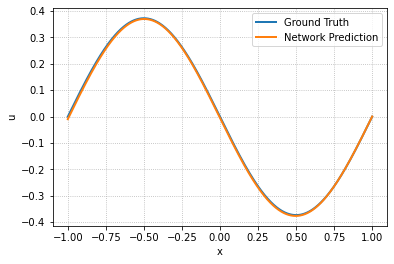

In [12]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [13]:
# Compute the relative L2 error norm (generalization error)
#relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  2.5421829894185066 %


In [14]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.027295475592836738 %


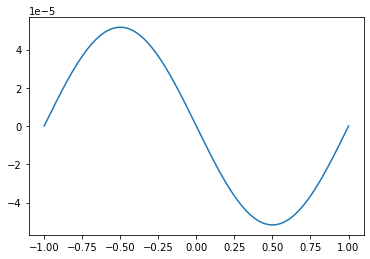

In [15]:
x = torch.linspace(-1, 1, 1000).reshape(-1,1)
y = -torch.sin(pi*x)*torch.exp(-pi**2 *torch.ones((1000,1)) )
plt.plot(x, y)